Analysis Notebook
================


1. Display (random) pictures from all datasets 
2. Plot of Loss-History
3. Plot of Train/Val-Accuracy-History
4. Display correct classified/ mis-classified Images from Validation Set
5. Confusion Matrix

In [1]:
import matplotlib.pyplot as plt
import itertools
import copy
import warnings
import json
import numpy as np
import os
import math
%load_ext autoreload
%autoreload 2

In [ ]:
# Imports

from Preprocessing.DatasetContainer import DatasetContainer
import torch
from Models.DenseNet161 import DenseNet161




In [2]:
# Load the entire session
session_directory = os.path.join("../Results", "final_02")
session_results = []

_, result_directories, _ = next(os.walk(session_directory))
for dir_name in result_directories:
    dir_path = os.path.join(session_directory, dir_name)
    log_path = os.path.join(dir_path, "training.log")
    param_path = os.path.join(dir_path, "params.json")
    
    # values for confusion matrix val are available for sessions from 2018_01_19 or later, uncomment to see other sessions
    confusion_matrix_path_val = os.path.join(dir_path, "confusion_matrix_val.npy")
    confusion_matrix_path_test = os.path.join(dir_path, "confusion_matrix_test.npy")
    confusion_matrix_path_test_asl = os.path.join(dir_path, "confusion_matrix_test_E2.npy")
    confusion_matrix_path_test_gfd = os.path.join(dir_path, "confusion_matrix_test_GFD.npy")

    # values for confusion matrix test and test_acc are available for sessions from 2018_01_19-16_17_24 or later
    #confusion_matrix_path_test = os.path.join(dir_path, "confusion_matrix_test.npy")
    #test_acc_path = os.path.join(dir_path, "test_acc.npy")
 
    results = {}

    try:
        confusion_matrix_val = np.load(confusion_matrix_path_val)
        results["confusion_matrix"] = confusion_matrix_val
        if dir_name == "best_model":
            confusion_matrix_test = np.load(confusion_matrix_path_test)
            confusion_matrix_test_asl = np.load(confusion_matrix_path_test_asl)
            confusion_matrix_test_gfd = np.load(confusion_matrix_path_test_gfd)


    except: 
        warnings.warn("Could not all necessary files. Maybe for your session these data are not recorded or there is an error in the defined path.")
    

    
    with open(log_path) as l, open(param_path) as p:
        log = json.load(l)
        params = json.load(p)
        results["log"] = log
        results["params"] = params
        
    results["dir_name"] = dir_name
    
    session_results.append(results)

In [3]:
# Extract session specific parameter combinations and the highest validation accuracy for each result
# ATTENTION: You have to specify the desired hyperparameters manually in this cell!

for result in session_results:
    params = result["params"]
    combination = {"lr": params["solver_params"]["optimizer_args"]["lr"],
                   "weight_decay": params["solver_params"]["optimizer_args"]["weight_decay"],
                   "hue_rand": params["data_params"]["augmentation_params"]["hue_rand"],
                   "brightness_rand": params["data_params"]["augmentation_params"]["brightness_rand"],
                   "crop_factor": params["data_params"]["augmentation_params"]["crop_factor"][0], 
                   "distortion_range": params["data_params"]["augmentation_params"]["distortion_range"]
                  }
    result["combination"] = combination
    
    result["val_acc"] = max(result["log"]["val_acc"])


In [4]:
# Sort the results

# Only by validation accuracy
#session_results = sorted(session_results, reverse=True, key=lambda x: x["val_acc"])

# By learning rate, then by validation accuracy
#session_results = sorted(session_results, reverse=True, key=lambda x: (x["params"]["solver_params"]["optimizer_args"]["lr"], x["val_acc"]))


try:
    print("number\t dir_name \t\t val_acc\t\t test_acc")
    for i, result in enumerate(session_results):
        print(i, "\t", result["dir_name"], "\t", result["val_acc"], "\t",result["test_acc"])
except:
    for i, result in enumerate(session_results):
        print(i, "\t", result["dir_name"], "\t", result["val_acc"])

number	 dir_name 		 val_acc		 test_acc
0 	 best_model 	 0.8791666666666667
1 	 high_augmentation_NEW 	 0.8494444444444443
2 	 high_augmentation_OLD 	 0.8616666666666668
3 	 only_ASL 	 0.858611111111111
4 	 only_ASL_val_on_GFD 	 0.19555555555555554
5 	 two_speaker_test_val 	 0.7705555555555554


In [5]:
### plot parameters
#fontsizes
fs_title = 24
fs_ax_labels = 20
fs_tick_labels=18
fs_legend = 20

is_final_plot = True

1. Random Pictures
=========

In [ ]:
# Load the dataset. Skip this section if you don't have it on your local machine.
data_params = session_results[0]["params"]["data_params"]

data_root_dir = "/Datasets/dataset_small"
speaker_config = data_params["split_config"]
augmentation_params = data_params["augmentation_params"]
augmentation_params["crop_factor"] = [0.6, 0.6]
augmentation_params["hue_rand"] = 0.08
augmentation_params["contrast_rand"] = 0.25
augmentation_params["saturation_rand"] = 0.3
data_set = DatasetContainer(data_root_dir, speaker_config, augmentation_params)
train_data, val_data, test_data = data_set.get_datasets()

print(data_params)

In [ ]:
class_names = ['a','b','c','d','e','f','g','h','i', 'k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

# Plot some pictures form the test and validation set

classes = [0, 5, 20, 21]
columns = 3
samples_per_class = 5
mean = np.array(data_set.mean)
std = np.array(data_set.std)

# Training set
for cls in classes:
    print("Class: {0} = {1}".format(cls, class_names[cls]))
    cls_data = [datum for datum in train_data if datum[1] == cls]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_idxs = [0,1,2,3,4]
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    
    for i, cls_datum in enumerate(rnd_cls_data, 1):
        plt.subplot(math.ceil(samples_per_class / float(columns)), columns, i)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0)*std + mean)
        plt.axis('off')
    plt.show()

2. Plot Loss-History
=========

In [ ]:
# Plot loss of specific results in a given range
idx_from = 0
idx_to = 4
mean_range = 30

fig_trloss=plt.figure(dpi= 80, facecolor='w', edgecolor='k')

plot = plt.subplot(2, 1, 1)
plt.title('Training loss',fontsize= fs_title)

for i, result in enumerate(session_results[idx_from:idx_to]):
    print(i, "\t", result["combination"])
    loss = result["log"]["train_loss"]
    mean_loss = [np.mean(loss[idx:idx+mean_range]) for idx in range(0, len(loss), mean_range)]
    plt.plot(mean_loss, '-', label=str(i))
plt.xlabel('Time', fontsize= fs_ax_labels)

plt.legend(loc='best', fontsize = fs_legend)
plt.gcf().set_size_inches(15, 12)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

3. Plot Train/Val-Accuracy-History
=========

0 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.08, 'brightness_rand': 0.5, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
1 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.3, 'brightness_rand': 0.8, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
2 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.2, 'brightness_rand': 0.75, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
3 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.08, 'brightness_rand': 0.5, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}


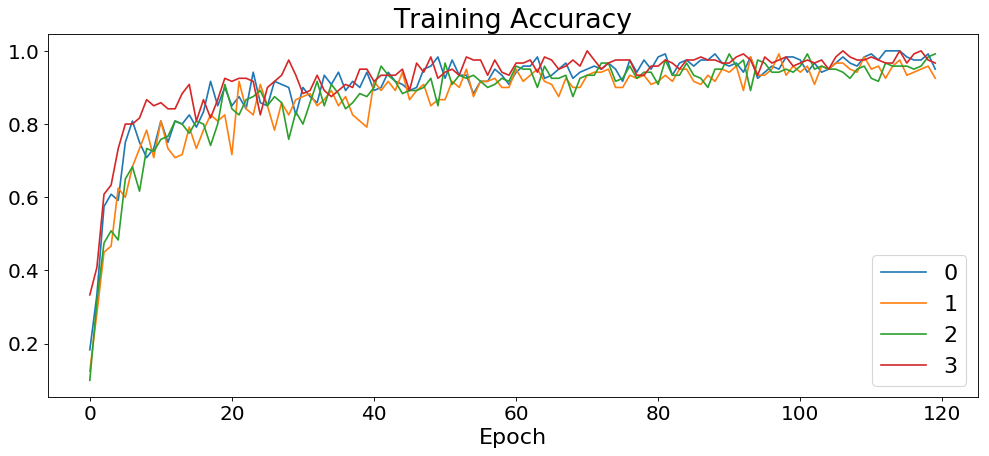

In [6]:
# Plot training accuracy
idx_from = 0
idx_to = 4

fig_tr_acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_tr_acc.add_subplot(111)

plt.title('Training Accuracy', fontsize=fs_title)
for i, result in enumerate(session_results[idx_from:idx_to]):
    print(i, "\t", result["combination"])
    plt.plot(result["log"]["train_acc"], '-', label=str(i))

plt.xlabel('Epoch', fontsize = fs_ax_labels)
plt.legend(loc='best', fontsize= fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

0 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.08, 'brightness_rand': 0.5, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
1 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.3, 'brightness_rand': 0.8, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
2 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.2, 'brightness_rand': 0.75, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
3 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.08, 'brightness_rand': 0.5, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
4 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.08, 'brightness_rand': 0.5, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}
5 	 {'lr': 0.001, 'weight_decay': 0.005, 'hue_rand': 0.08, 'brightness_rand': 0.5, 'crop_factor': 1.0, 'distortion_range': [1.0, 1.0]}


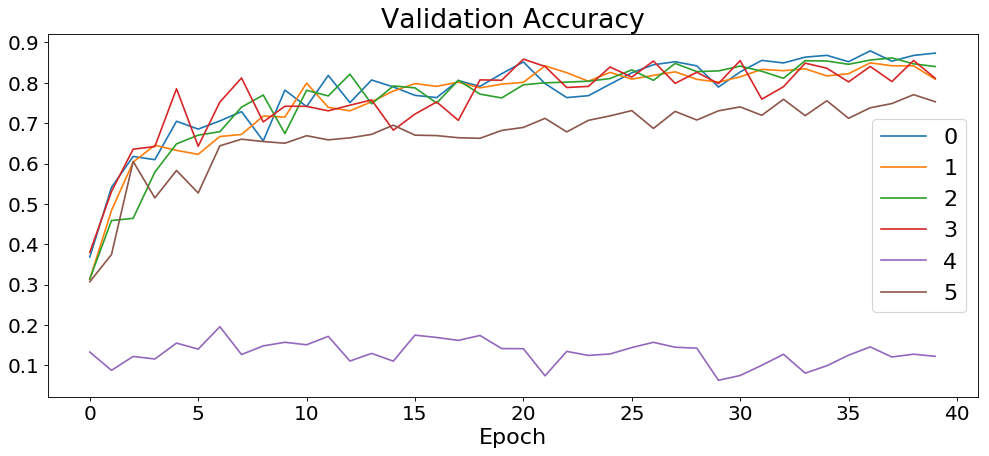

In [7]:
# Plot valdiation accuracy
idx_from = 0
idx_to = 6

fig_val_acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_val_acc.add_subplot(111)

plt.title('Validation Accuracy', fontsize=fs_title)
for i, result in enumerate(session_results[idx_from:idx_to]):
    print(i, "\t", result["combination"])
    plt.plot(result["log"]["val_acc"], '-', label=str(i))



plt.xlabel('Epoch', fontsize = fs_ax_labels)
plt.legend(loc='best', fontsize= fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()


In [ ]:
# Final plot Whole best dataset

# Plot valdiation accuracy
idx_from = 0
idx_to = 6

fig_combi_model=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_combi_model.add_subplot(111)

plt.title('Validation Accuracy', fontsize=fs_title)
for i, result in enumerate(session_results[idx_from:idx_to]):
    #print(i, "\t", result["combination"])
    if result["dir_name"] == "best_model":
        val = result["log"]["val_acc"]
        ind_max = val.index(max(val))
        plt.plot(val, '-', label='Setting 2', linewidth=2.5, color='tab:blue')
        tr_result = result['log']['train_acc']
        tr = tr_result[::3]
        plt.plot(tr, ':', label='',alpha=0.6, color='tab:blue')
        plt.plot([ind_max, ind_max], [0.5,1.1], '--', color='tab:orange' )
        plt.plot(ind_max,val[ind_max],'x', color = 'tab:red', markeredgewidth  = 5, markersize= 10,label = "Early Stopping")

    elif result["dir_name"] =="two_speaker_test_val":
        plt.plot(result["log"]["val_acc"], '-.', label='Setting 3', linewidth=2.5, color='tab:grey')
    else:
        print(result["dir_name"])




plt.text(0, 0.95,'Training Accuracy', fontsize= fs_tick_labels,bbox=dict(facecolor='none', edgecolor='tab:blue', alpha = 0.6, pad=10.0))
plt.text(29.5, 1.05,'Best Model', fontsize= fs_tick_labels,bbox=dict(facecolor='none', edgecolor='tab:orange', alpha = 0.6, pad=10.0))

ax = plt.gca()
ax.arrow(2.5, 0.92, 3, -0.05, head_width=0.05, head_length=0.4, fc='k', ec='k')
plt.xlabel('Epoch', fontsize = fs_ax_labels)
plt.legend(loc='best', fontsize= fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

best_model
high_augmentation_NEW
high_augmentation_OLD
found em
two_speaker_test_val


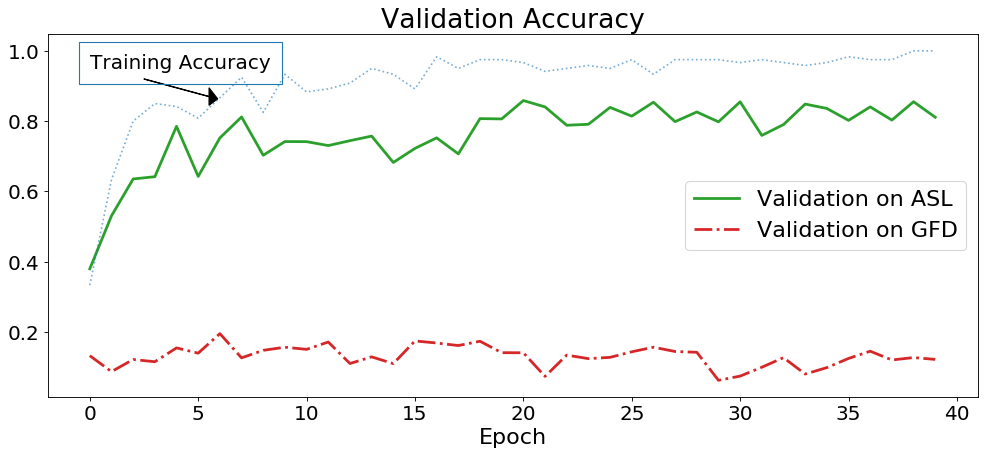

In [8]:
# Final plot ASL only

# Final plot Whole best dataset

# Plot valdiation accuracy
idx_from = 0
idx_to = 6

fig_asl_model=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_asl_model.add_subplot(111)

plt.title('Validation Accuracy', fontsize=fs_title)
for i, result in enumerate(session_results[idx_from:idx_to]):
    #print(i, "\t", result["combination"])
    if result["dir_name"] == "only_ASL":
        plt.plot(result["log"]["val_acc"], '-', label='Validation on ASL', linewidth=2.5, color='tab:green')
        tr_result = result['log']['train_acc']
        tr = tr_result[::3]
        plt.plot(tr, ':', label='',alpha=0.6, color='tab:blue')
    elif result["dir_name"] =="only_ASL_val_on_GFD":
        print('found em')
        plt.plot(result["log"]["val_acc"], '-.', label='Validation on GFD', linewidth=2.5, color='tab:red')
    else:
        print(result["dir_name"])

plt.text(0, 0.95,'Training Accuracy', fontsize= fs_tick_labels,bbox=dict(facecolor='none', edgecolor='tab:blue', pad=10.0))
ax = plt.gca()
ax.arrow(2.5, 0.92, 3, -0.05, head_width=0.05, head_length=0.4, fc='k', ec='k')

plt.xlabel('Epoch', fontsize = fs_ax_labels)
plt.legend(loc='best', fontsize= fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

In [ ]:
### Plot overfitting curves (difference between train_acc and small_val_acc)
idx_from = 0
idx_to = 1
mean_range = 5

fig_overfitting=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_overfitting.add_subplot(111)

plt.title('Overfitting', fontsize=fs_title)
for i, result in enumerate(session_results[idx_from:idx_to]):
    print(i, "\t", result["combination"])
    overfitting = [t-v for t, v in zip(result["log"]["train_acc"], result["log"]["small_val_acc"])]
    overfitting = [np.mean(overfitting[idx:idx+mean_range]) for idx in range(0, len(overfitting), mean_range)]
    average = np.mean(overfitting)
    at_end = overfitting[-1]
    print("\tAverage:%.3f\tOverfitting at end:%.3f" % (average, at_end))
    plt.plot(overfitting, '-', label=str(i))
plt.xlabel('Time', fontsize=fs_ax_labels)
plt.ylabel('acc (train) - acc (val)', fontsize=fs_ax_labels)
plt.legend(loc='best', fontsize=fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)

plt.show()

In [ ]:
# Plot train/small_val/val accuracy from specific result

log = session_results[0]["log"]
train_acc = log["train_acc"]
small_val_acc = log["small_val_acc"]
val_acc = log["val_acc"]

# Calculate scaling for x-axis of the validation accuracy
epoch = int(len(small_val_acc)/len(val_acc))
x_val_acc = list(range(epoch, len(small_val_acc)+epoch, epoch))

# plot train/small_val/val accuracy
fig_3acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_3acc.add_subplot(111)

plt.title('Accuracy', fontsize = fs_title)
plt.plot(train_acc, '-', label='train')
plt.plot(small_val_acc, '-', label='small_val')
plt.plot(x_val_acc, val_acc, '-', label='val')
plt.xlabel('Time', fontsize=fs_ax_labels)
plt.legend(loc='lower right', fontsize=fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

4. Correct classified/ mis-classified Images from Validation Set
=========

In [ ]:
# Run test in online mode on validation set
# ATTENTION: You have to manually download the model from the gcloud instance because it has not been added to the git.  
# NOTE: This could take a while!

result = session_results[0]

model_path = os.path.join(session_directory, result["dir_name"], "model.pt")
model_params = result["params"]["model_params"]
model = DenseNet161(no_denseblock_train=model_params["no_denseblock_train"], num_classes=model_params["num_classes"])
model.load_state_dict(torch.load(model_path))
model.eval()

online_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=2)

classes = {}
for i in range(24):
    classes[i] = []

predictions = {"wrong": copy.deepcopy(classes),
               "correct": copy.deepcopy(classes)}

correct = 0
wrong = 0

for image, target in online_loader:
    image = torch.autograd.Variable(image)
    if torch.cuda.is_available():
        image = image.cuda()
        model.cuda()
    output = model(image)
    _, prediction = torch.max(output, 1)
    prediction = prediction.cpu().data[0]
    if prediction == target:
        predictions["correct"][target[0]].append(image.cpu().data.numpy()[0])
        correct += 1
    else:
        predictions["wrong"][target[0]].append((image.cpu().data.numpy()[0], prediction))
        wrong +=1

print("correct:", correct)
print("wrong:", wrong)

In [ ]:
# Randomly show some correctly classified images from the strongest classes
n = 3
show_images_per_class = 3

corrects = predictions["correct"]

class_strengths = sorted([(key, len(corrects[key])) for key in corrects], reverse=True, key=lambda x: x[1])
strongest_classes = [key for key, cnt in class_strengths]

for i, cls in enumerate(strongest_classes[0:n]):
    cls_corrects = corrects[cls]
    images_in_class = len(cls_corrects)
    image_idxs = [np.random.randint(images_in_class) for j in range(min(show_images_per_class, images_in_class))]
    for j, idx in enumerate(image_idxs, 1):               
        image = cls_corrects[idx]
        plt.subplot(n, show_images_per_class, i * show_images_per_class + j)
        plt.imshow(image.transpose(1,2,0) * std + mean)
        plt.axis('off')
    plt.show()
    

In [ ]:
# Randomly show some incorrectly classified images from the weakest classes
n = 3
show_images_per_class = 3

wrongs = predictions["wrong"]

class_strengths = sorted([(key, len(wrongs[key])) for key in wrongs], reverse=True, key=lambda x: x[1])
weakest_classes = [key for key, cnt in class_strengths]

for i, cls in enumerate(weakest_classes[0:n]):
    cls_wrongs = wrongs[cls]
    images_in_class = len(cls_wrongs)
    image_idxs = [np.random.randint(images_in_class) for j in range(min(show_images_per_class, images_in_class))]
    for j, idx in enumerate(image_idxs, 1):
        image, wrong_prediction = cls_wrongs[idx]
        print("Class %i but predicted %i" % (cls, wrong_prediction))
        plt.subplot(n, show_images_per_class, i * show_images_per_class + j)
        plt.imshow(image.transpose(1,2,0) * std + mean)
        plt.axis('off')
    plt.show()
    

5. Confusion Matrix
==========

In [ ]:
fs_factor = 1.3
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax = plt.gca()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=fs_tick_labels) 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    fmt = '.2f'# if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j] > 5e-3:
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=17)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=fs_ax_labels*fs_factor)
    plt.xlabel('Predicted label', fontsize=fs_ax_labels*fs_factor)

In [ ]:
# Plot confusion matrix of a specific result
confusion_matrix_val = session_results[0]["confusion_matrix"]

#cm_asl = confusion_matrix_test_asl
cm_asl = confusion_matrix_test_asl.astype('float') / confusion_matrix_test_asl.sum(axis=1)[:, np.newaxis]
cm_gfd = confusion_matrix_test_gfd.astype('float') / confusion_matrix_test_gfd.sum(axis=1)[:, np.newaxis]
confusion_matrix_fifty_fifty = 0.5*cm_asl + 0.5*cm_gfd


class_names = ['a','b','c','d','e','f','g','h','i', 'k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
# fig_val_matrix=plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
# plot = fig_val_matrix.add_subplot(111)
# plot_confusion_matrix(confusion_matrix_val, classes=class_names, normalize=True)
# plt.title('Confusion matrix of validation data', fontsize = fs_title*fs_factor)
# plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels*fs_factor)
# plt.show()

fig_test_matrix=plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
plot = fig_test_matrix.add_subplot(111)
plot_confusion_matrix(confusion_matrix_fifty_fifty, classes=class_names, normalize=True)
plt.title('Confusion Matrix of Test Data', fontsize = fs_title*fs_factor)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels*fs_factor)
plt.show()


In [9]:
### Save graphics
path = '../Poster/GraphicsClipboard/'
#fig_trloss.savefig(path+'tr_loss.pdf',bbox_inches='tight', format='pdf')
# fig_val_acc.savefig(path+'val_acc.pdf',bbox_inches='tight', format='pdf')
# fig_tr_acc.savefig(path+'tr_acc.pdf',bbox_inches='tight', format='pdf')

fig_asl_model.savefig(path+'acc_asl.pdf',bbox_inches='tight', format='pdf')
#fig_combi_model.savefig(path+'acc_combi.pdf',bbox_inches='tight', format='pdf')

#fig_overfitting.savefig(path+'overfitting.pdf',bbox_inches='tight', format='pdf')
#fig_3acc.savefig(path+'3_accuracies.pdf',bbox_inches='tight', format='pdf')
#fig_val_matrix.savefig(path+'val_conf_matrix.pdf',bbox_inches='tight', format='pdf')
#fig_test_matrix.savefig(path+'test_conf_matrix.pdf',bbox_inches='tight', format='pdf')

